# SageMaker Linear Learner Exercise

This notebook walks you through training Amazon SageMaker's **Linear Learner** algorithm for both **classification** and **regression** tasks, using **Batch Transform** for predictions.

## What You'll Learn
1. How to prepare data in Linear Learner's required format
2. How to configure and train a Linear Learner model for classification
3. How to configure and train a Linear Learner model for regression
4. How to use **Batch Transform** for predictions (no endpoint deployment)
5. How to evaluate model performance with comprehensive metrics

## What is Linear Learner?
Linear Learner is a supervised learning algorithm that can be used for both **classification** and **regression** problems. Under the hood, it trains multiple models with different hyperparameters in parallel and selects the best one.

Key features:
- **Binary/Multiclass Classification**: Logistic regression with various loss functions
- **Regression**: Linear regression with L1/L2 regularization
- **Automatic model tuning**: Trains multiple models in parallel
- **Built-in data normalization**: Handles feature scaling automatically

## Why Batch Transform?
- **No endpoint costs**: Only pay for compute during the transform job
- **Better for batch predictions**: Ideal for evaluating models on test sets
- **No cleanup required**: Resources automatically terminate after job completes

## Prerequisites
- SageMaker notebook instance or Studio
- IAM role with S3 and SageMaker permissions

---

## Step 1: Setup and Imports

In [ ]:
# Install required packages (if needed)
!pip install -q matplotlib pandas numpy sagemaker boto3 scikit-learn seaborn

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.transformer import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    # Classification metrics
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, log_loss,
    balanced_accuracy_score, matthews_corrcoef,
    # Regression metrics
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score,
    max_error, median_absolute_error
)
import json
import os
from datetime import datetime
import time
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure AWS session from environment variables
aws_profile = os.getenv('AWS_PROFILE')
aws_region = os.getenv('AWS_REGION', 'us-west-2')
sagemaker_role = os.getenv('SAGEMAKER_ROLE_ARN')

if aws_profile:
    boto3.setup_default_session(profile_name=aws_profile, region_name=aws_region)
else:
    boto3.setup_default_session(region_name=aws_region)

# SageMaker session and role
sagemaker_session = sagemaker.Session()

# Use environment variable for role, or fall back to execution role if running in SageMaker
if sagemaker_role:
    role = sagemaker_role
else:
    role = get_execution_role()

region = sagemaker_session.boto_region_name

print(f"AWS Profile: {aws_profile or 'default'}")
print(f"SageMaker Role: {role}")
print(f"Region: {region}")
print(f"SageMaker SDK Version: {sagemaker.__version__}")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/david.jarmoluk/Library/Application Support/sagemaker/config.yaml
AWS Profile: brightech-secondary
SageMaker Role: arn:aws:iam::096816224238:role/service-role/AmazonSageMaker-ExecutionRole-20251113T125927
Region: us-west-2
SageMaker SDK Version: 2.255.0


In [2]:
# Configuration - MODIFY THESE FOR YOUR ENVIRONMENT
BUCKET_NAME = sagemaker_session.default_bucket()  # Or specify your bucket
PREFIX = "linear_learner"

# Dataset parameters
NUM_SAMPLES = 5000
TEST_RATIO = 0.2

print(f"S3 Bucket: {BUCKET_NAME}")
print(f"S3 Prefix: {PREFIX}")

S3 Bucket: sagemaker-us-west-2-096816224238
S3 Prefix: linear_learner


## Step 2: Generate Synthetic Data

We'll generate two types of data:
1. **Classification**: Customer churn prediction
2. **Regression**: House price prediction

In [3]:
def generate_classification_data(num_samples=5000, seed=42):
    """
    Generate synthetic customer churn data for binary classification.
    """
    np.random.seed(seed)
    
    feature_names = [
        'tenure_months', 'monthly_charges', 'total_charges', 'support_tickets',
        'contract_type', 'payment_method', 'online_security', 'tech_support',
        'internet_service', 'num_products'
    ]
    
    # Generate features
    tenure = np.random.exponential(scale=24, size=num_samples).clip(1, 72)
    monthly_charges = np.random.normal(65, 30, num_samples).clip(20, 150)
    total_charges = tenure * monthly_charges * np.random.uniform(0.8, 1.0, num_samples)
    support_tickets = np.random.poisson(2, num_samples)
    contract_type = np.random.choice([0, 1, 2], num_samples, p=[0.5, 0.3, 0.2])
    payment_method = np.random.choice([0, 1, 2, 3], num_samples)
    online_security = np.random.choice([0, 1], num_samples, p=[0.6, 0.4])
    tech_support = np.random.choice([0, 1], num_samples, p=[0.5, 0.5])
    internet_service = np.random.choice([0, 1, 2], num_samples, p=[0.2, 0.4, 0.4])
    num_products = np.random.choice([1, 2, 3, 4, 5], num_samples, p=[0.3, 0.3, 0.2, 0.15, 0.05])
    
    X = np.column_stack([
        tenure, monthly_charges, total_charges, support_tickets,
        contract_type, payment_method, online_security, tech_support,
        internet_service, num_products
    ])
    
    # Generate labels based on realistic churn patterns
    churn_score = (
        -0.05 * tenure + 0.02 * monthly_charges + 0.1 * support_tickets +
        -0.5 * contract_type - 0.3 * online_security - 0.3 * tech_support +
        0.2 * (internet_service == 2) - 0.1 * num_products +
        np.random.normal(0, 0.5, num_samples)
    )
    
    churn_prob = 1 / (1 + np.exp(-churn_score))
    y = (np.random.random(num_samples) < churn_prob).astype(float)
    
    return X.astype(np.float32), y.astype(np.float32), feature_names

In [4]:
def generate_regression_data(num_samples=5000, seed=42):
    """
    Generate synthetic house price data for regression.
    """
    np.random.seed(seed)
    
    feature_names = [
        'sqft', 'bedrooms', 'bathrooms', 'lot_size_acres', 'year_built',
        'garage_capacity', 'has_pool', 'distance_to_city', 'school_rating', 'crime_rate'
    ]
    
    sqft = np.random.normal(2000, 800, num_samples).clip(500, 6000)
    bedrooms = np.random.choice([1, 2, 3, 4, 5, 6], num_samples, p=[0.05, 0.15, 0.35, 0.30, 0.12, 0.03])
    bathrooms = np.minimum(bedrooms, np.random.choice([1, 2, 3, 4], num_samples, p=[0.2, 0.4, 0.3, 0.1]))
    lot_size = np.random.exponential(0.3, num_samples).clip(0.1, 5.0)
    year_built = np.random.normal(1990, 20, num_samples).clip(1920, 2024).astype(int)
    garage_capacity = np.random.choice([0, 1, 2, 3], num_samples, p=[0.1, 0.25, 0.50, 0.15])
    has_pool = np.random.choice([0, 1], num_samples, p=[0.75, 0.25])
    distance_to_city = np.random.exponential(10, num_samples).clip(1, 50)
    school_rating = np.random.uniform(3, 10, num_samples)
    crime_rate = np.random.exponential(5, num_samples).clip(0.5, 30)
    
    X = np.column_stack([
        sqft, bedrooms, bathrooms, lot_size, year_built,
        garage_capacity, has_pool, distance_to_city, school_rating, crime_rate
    ])
    
    # Generate prices
    price = (
        50000 + 150 * sqft + 15000 * bedrooms + 20000 * bathrooms +
        30000 * lot_size + 1000 * (year_built - 1950) + 15000 * garage_capacity +
        40000 * has_pool - 2000 * distance_to_city + 10000 * school_rating -
        3000 * crime_rate + np.random.normal(0, 30000, num_samples)
    )
    
    y = np.maximum(price, 50000).astype(np.float32)
    
    return X.astype(np.float32), y, feature_names

In [5]:
# Generate both datasets
print("Generating Classification Data (Customer Churn)...")
X_clf, y_clf, clf_features = generate_classification_data(NUM_SAMPLES)

print("Generating Regression Data (House Prices)...")
X_reg, y_reg, reg_features = generate_regression_data(NUM_SAMPLES)

print(f"\nClassification Dataset:")
print(f"  Shape: {X_clf.shape}")
print(f"  Churn Rate: {y_clf.mean()*100:.1f}%")
print(f"  Features: {clf_features}")

print(f"\nRegression Dataset:")
print(f"  Shape: {X_reg.shape}")
print(f"  Price Range: ${y_reg.min():,.0f} - ${y_reg.max():,.0f}")
print(f"  Mean Price: ${y_reg.mean():,.0f}")
print(f"  Features: {reg_features}")

Generating Classification Data (Customer Churn)...
Generating Regression Data (House Prices)...

Classification Dataset:
  Shape: (5000, 10)
  Churn Rate: 43.9%
  Features: ['tenure_months', 'monthly_charges', 'total_charges', 'support_tickets', 'contract_type', 'payment_method', 'online_security', 'tech_support', 'internet_service', 'num_products']

Regression Dataset:
  Shape: (5000, 10)
  Price Range: $198,802 - $1,093,279
  Mean Price: $558,487
  Features: ['sqft', 'bedrooms', 'bathrooms', 'lot_size_acres', 'year_built', 'garage_capacity', 'has_pool', 'distance_to_city', 'school_rating', 'crime_rate']


In [6]:
def split_data(X, y, test_ratio=0.2, seed=42):
    """Split data into train and test sets."""
    np.random.seed(seed)
    indices = np.random.permutation(len(y))
    test_size = int(len(y) * test_ratio)
    
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split classification data
X_clf_train, X_clf_test, y_clf_train, y_clf_test = split_data(X_clf, y_clf, TEST_RATIO)

# Split regression data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = split_data(X_reg, y_reg, TEST_RATIO)

print(f"Classification - Train: {len(y_clf_train)}, Test: {len(y_clf_test)}")
print(f"Regression - Train: {len(y_reg_train)}, Test: {len(y_reg_test)}")

Classification - Train: 4000, Test: 1000
Regression - Train: 4000, Test: 1000


## Step 3: Visualize the Data

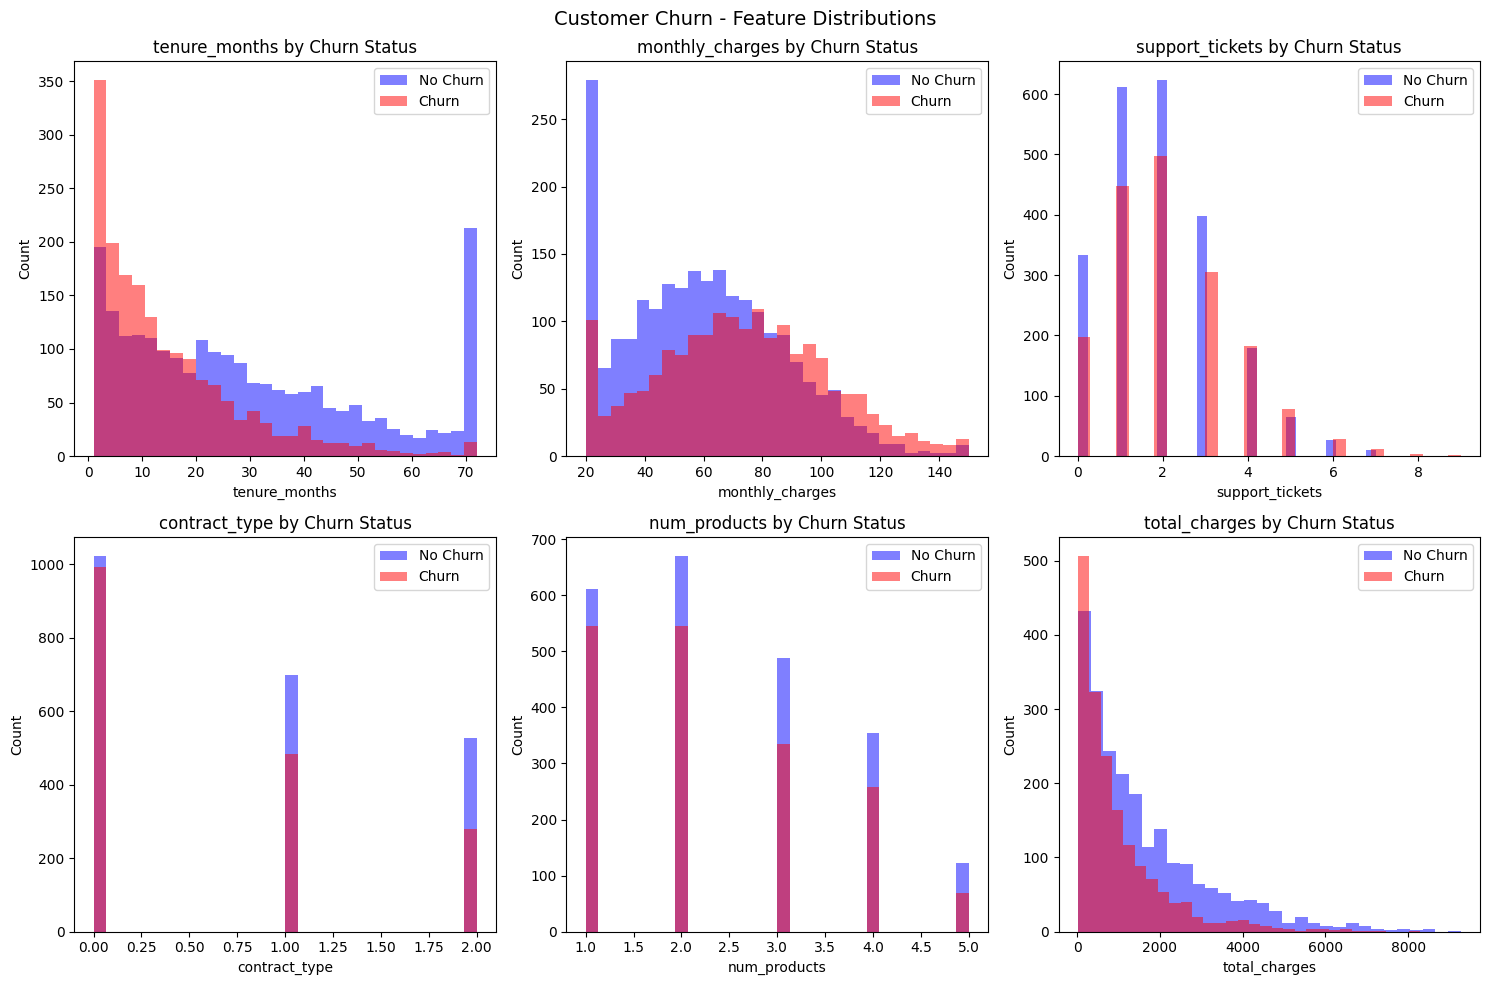

In [7]:
# Visualize classification data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Create DataFrame for easier plotting
clf_df = pd.DataFrame(X_clf_train, columns=clf_features)
clf_df['churn'] = y_clf_train

features_to_plot = ['tenure_months', 'monthly_charges', 'support_tickets', 
                    'contract_type', 'num_products', 'total_charges']

for idx, feature in enumerate(features_to_plot):
    ax = axes.flatten()[idx]
    
    for label, color, name in [(0, 'blue', 'No Churn'), (1, 'red', 'Churn')]:
        subset = clf_df[clf_df['churn'] == label][feature]
        ax.hist(subset, bins=30, alpha=0.5, color=color, label=name)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'{feature} by Churn Status')

plt.suptitle('Customer Churn - Feature Distributions', fontsize=14)
plt.tight_layout()
plt.show()

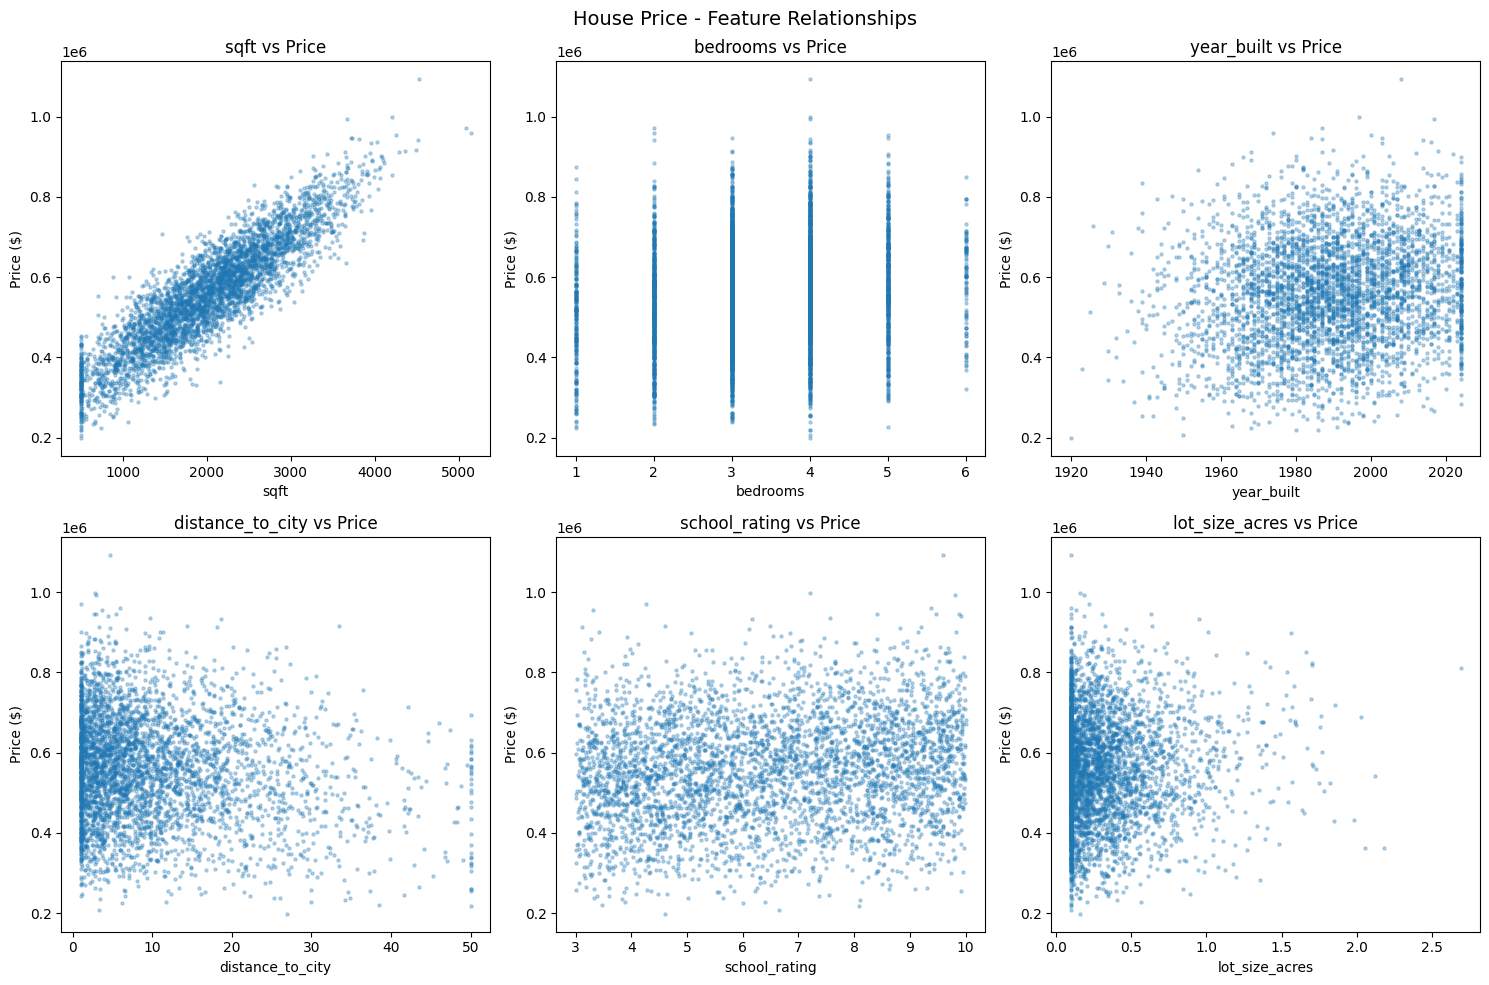

In [8]:
# Visualize regression data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

reg_df = pd.DataFrame(X_reg_train, columns=reg_features)
reg_df['price'] = y_reg_train

features_to_plot = ['sqft', 'bedrooms', 'year_built', 
                    'distance_to_city', 'school_rating', 'lot_size_acres']

for idx, feature in enumerate(features_to_plot):
    ax = axes.flatten()[idx]
    ax.scatter(reg_df[feature], reg_df['price'], alpha=0.3, s=5)
    ax.set_xlabel(feature)
    ax.set_ylabel('Price ($)')
    ax.set_title(f'{feature} vs Price')

plt.suptitle('House Price - Feature Relationships', fontsize=14)
plt.tight_layout()
plt.show()

## Step 4: Prepare Data for SageMaker Linear Learner

Linear Learner accepts data in several formats:
1. **CSV**: Label in first column, followed by features (for training)
2. **CSV**: Features only (for batch transform inference)

We'll prepare both formats.

In [9]:
# Create local data directory
os.makedirs('data/classification', exist_ok=True)
os.makedirs('data/regression', exist_ok=True)

def save_csv_for_training(X, y, filepath):
    """Save data in SageMaker Linear Learner CSV format (label first) for training."""
    data = np.column_stack([y.reshape(-1, 1), X])
    np.savetxt(filepath, data, delimiter=',', fmt='%.6f')

def save_csv_for_inference(X, filepath):
    """Save features only for batch transform inference."""
    np.savetxt(filepath, X, delimiter=',', fmt='%.6f')

# Save classification data
save_csv_for_training(X_clf_train, y_clf_train, 'data/classification/train.csv')
save_csv_for_inference(X_clf_test, 'data/classification/test_features.csv')
# Also save test labels locally for evaluation
np.savetxt('data/classification/test_labels.csv', y_clf_test, delimiter=',', fmt='%.6f')

# Save regression data
save_csv_for_training(X_reg_train, y_reg_train, 'data/regression/train.csv')
save_csv_for_inference(X_reg_test, 'data/regression/test_features.csv')
# Also save test labels locally for evaluation
np.savetxt('data/regression/test_labels.csv', y_reg_test, delimiter=',', fmt='%.6f')

print("Data saved locally:")
print(f"  Classification train: {os.path.getsize('data/classification/train.csv') / 1024:.1f} KB")
print(f"  Classification test features: {os.path.getsize('data/classification/test_features.csv') / 1024:.1f} KB")
print(f"  Regression train: {os.path.getsize('data/regression/train.csv') / 1024:.1f} KB")
print(f"  Regression test features: {os.path.getsize('data/regression/test_features.csv') / 1024:.1f} KB")

Data saved locally:
  Classification train: 402.9 KB
  Classification test features: 91.9 KB
  Regression train: 431.3 KB
  Regression test features: 94.1 KB


In [10]:
# Upload to S3
s3_client = boto3.client('s3')

# Classification data
clf_train_s3 = f"{PREFIX}/classification/train/train.csv"
clf_test_s3 = f"{PREFIX}/classification/test/test_features.csv"

s3_client.upload_file('data/classification/train.csv', BUCKET_NAME, clf_train_s3)
s3_client.upload_file('data/classification/test_features.csv', BUCKET_NAME, clf_test_s3)

# Regression data
reg_train_s3 = f"{PREFIX}/regression/train/train.csv"
reg_test_s3 = f"{PREFIX}/regression/test/test_features.csv"

s3_client.upload_file('data/regression/train.csv', BUCKET_NAME, reg_train_s3)
s3_client.upload_file('data/regression/test_features.csv', BUCKET_NAME, reg_test_s3)

print("Data uploaded to S3:")
print(f"  Classification train: s3://{BUCKET_NAME}/{clf_train_s3}")
print(f"  Classification test: s3://{BUCKET_NAME}/{clf_test_s3}")
print(f"  Regression train: s3://{BUCKET_NAME}/{reg_train_s3}")
print(f"  Regression test: s3://{BUCKET_NAME}/{reg_test_s3}")

Data uploaded to S3:
  Classification train: s3://sagemaker-us-west-2-096816224238/linear_learner/classification/train/train.csv
  Classification test: s3://sagemaker-us-west-2-096816224238/linear_learner/classification/test/test_features.csv
  Regression train: s3://sagemaker-us-west-2-096816224238/linear_learner/regression/train/train.csv
  Regression test: s3://sagemaker-us-west-2-096816224238/linear_learner/regression/test/test_features.csv


---

# Part A: Binary Classification (Customer Churn)

## Step 5A: Configure and Train the Classification Model

### Understanding Linear Learner Hyperparameters

**predictor_type** (Required)
- Specifies the type of problem you're solving
- `binary_classifier`: For two-class classification (churn/no-churn, fraud/not-fraud)
- `multiclass_classifier`: For problems with 3+ classes
- `regressor`: For predicting continuous values (prices, temperatures)
- This determines the loss function and output format used internally

**feature_dim** (Required)
- The number of input features in your dataset
- Must match exactly—if your data has 10 columns (excluding label), set to 10
- Linear Learner creates one weight per feature, so this defines model size

**epochs**
- Number of complete passes through the training data
- Each epoch, the model sees every training example once and updates weights
- More epochs = more learning opportunities, but risk of overfitting
- Too few: model hasn't converged; Too many: memorizes training data
- Typical range: 10-100 (start with 15-20, increase if loss is still decreasing)

**mini_batch_size**
- Number of samples processed before updating model weights
- Smaller batches: more frequent updates, noisier gradients, can escape local minima
- Larger batches: smoother gradients, faster training, but may get stuck
- Typical range: 32-1000 (200 is a good default for medium datasets)
- Rule of thumb: larger datasets can use larger batch sizes

**learning_rate**
- How much to adjust weights based on each gradient update
- Too high: training oscillates or diverges (loss jumps around)
- Too low: training is very slow, may get stuck
- Typical range: 0.001-1.0 (0.1 is a good starting point for Linear Learner)
- Linear Learner can auto-tune this if you set `learning_rate: "auto"`

**optimizer**
- Algorithm used to update weights based on gradients
- `sgd`: Stochastic Gradient Descent—simple, works well with proper learning rate
- `adam`: Adaptive Moment Estimation—adjusts learning rate per-parameter, often converges faster
- `rmsprop`: Similar to Adam, good for non-stationary problems
- `auto`: Let SageMaker choose (usually picks adam)
- Recommendation: Start with `adam`, try `sgd` if you want more control

**l1** (L1 Regularization / Lasso)
- Adds penalty proportional to absolute value of weights: `loss + l1 * sum(|weights|)`
- Encourages sparsity—pushes small weights to exactly zero
- Useful for feature selection (identifies which features matter)
- Higher values = more aggressive feature elimination
- Typical range: 0.0001-0.1 (start with 0.001)

**wd** (Weight Decay / L2 Regularization)
- Adds penalty proportional to squared weights: `loss + wd * sum(weights^2)`
- Prevents any single weight from becoming too large
- Encourages all features to contribute small amounts rather than few features dominating
- Helps prevent overfitting by keeping model "simple"
- Typical range: 0.0001-0.01 (start with 0.0001)

**normalize_data**
- Whether to automatically normalize input features before training
- Linear models are sensitive to feature scales—a feature ranging 0-1000 will dominate one ranging 0-1
- `true`: SageMaker computes mean and std of each feature, then standardizes to zero mean, unit variance
- `false`: Use only if you've already normalized your data
- Almost always set to `true` for Linear Learner

**normalize_label**
- Whether to normalize the target variable (for regression only)
- For regression: `true` helps when target has large values (e.g., house prices in hundreds of thousands)
- For classification: always `false` (labels are 0/1)

**num_models**
- How many models to train in parallel with different hyperparameter combinations
- `auto`: SageMaker trains multiple models and selects the best one
- Specific number (e.g., 32): Train exactly that many variants
- This is a key feature of Linear Learner—automatic model selection
- Higher values explore more hyperparameter space but cost more compute time

### Classification-Specific Hyperparameters

**binary_classifier_model_selection_criteria**
- How to choose the best model among the `num_models` trained
- `accuracy`: Maximize overall accuracy (good when classes are balanced)
- `f1`: Maximize F1 score (balance precision and recall)
- `precision_at_target_recall`: Maximize precision while maintaining specified recall
- `recall_at_target_precision`: Maximize recall while maintaining specified precision
- `cross_entropy_loss`: Minimize log loss (good for probability calibration)
- Use `precision_at_target_recall` when false negatives are costly (e.g., churn—you want to catch most churners)

**target_recall** / **target_precision**
- Used with `precision_at_target_recall` or `recall_at_target_precision`
- Example: `target_recall: 0.9` means "find the model with highest precision that still catches 90% of positive cases"
- For churn: high target_recall ensures you identify most at-risk customers
- For fraud: high target_precision reduces false alarms

**positive_example_weight_mult**
- How to handle class imbalance (e.g., 5% churn rate means 20x more non-churners)
- `balanced`: Automatically weight positive class inversely to its frequency
- `none`: No reweighting (assumes balanced classes)
- Specific value (e.g., 2.0): Weight positive examples by this factor
- Use `balanced` when one class is significantly rarer than the other

In [11]:
# Get the Linear Learner container image
linear_learner_image = retrieve(
    framework='linear-learner',
    region=region,
    version='1'
)

print(f"Linear Learner Image URI: {linear_learner_image}")

Linear Learner Image URI: 174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1


In [12]:
# Create the classification estimator
clf_estimator = Estimator(
    image_uri=linear_learner_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/classification/output',
    sagemaker_session=sagemaker_session,
    base_job_name='linear-learner-churn'
)

In [13]:
# Set classification hyperparameters
clf_hyperparameters = {
    # Task type
    "predictor_type": "binary_classifier",
    
    # Number of features
    "feature_dim": X_clf_train.shape[1],
    
    # Training parameters
    "epochs": 15,
    "mini_batch_size": 200,
    
    # Regularization
    "l1": 0.001,
    "wd": 0.0001,  # L2 weight decay
    
    # Optimization
    "learning_rate": 0.1,
    "optimizer": "adam",
    
    # Model selection
    "num_models": "auto",  # Train multiple models and select best
    
    # Normalization (important for linear models!)
    "normalize_data": "true",
    "normalize_label": "false",
    
    # Binary classification specific
    "binary_classifier_model_selection_criteria": "precision_at_target_recall",
    "target_recall": 0.9,  # Optimize precision while maintaining 90% recall
    "positive_example_weight_mult": "balanced",  # Handle class imbalance
}

clf_estimator.set_hyperparameters(**clf_hyperparameters)

print("Classification Hyperparameters:")
for k, v in clf_hyperparameters.items():
    print(f"  {k}: {v}")

Classification Hyperparameters:
  predictor_type: binary_classifier
  feature_dim: 10
  epochs: 15
  mini_batch_size: 200
  l1: 0.001
  wd: 0.0001
  learning_rate: 0.1
  optimizer: adam
  num_models: auto
  normalize_data: true
  normalize_label: false
  binary_classifier_model_selection_criteria: precision_at_target_recall
  target_recall: 0.9
  positive_example_weight_mult: balanced


In [14]:
# Define training input
clf_train_input = TrainingInput(
    s3_data=f's3://{BUCKET_NAME}/{clf_train_s3}',
    content_type='text/csv'
)

print("Starting classification training job...")
print("This will take approximately 3-5 minutes.\n")

clf_estimator.fit({'train': clf_train_input}, wait=True, logs=True)

INFO:sagemaker:Creating training-job with name: linear-learner-churn-2025-12-10-23-24-39-357


Starting classification training job...
This will take approximately 3-5 minutes.

2025-12-10 23:24:40 Starting - Starting the training job...
2025-12-10 23:25:15 Downloading - Downloading input data......
2025-12-10 23:26:01 Downloading - Downloading the training image......
2025-12-10 23:27:22 Training - Training in-progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/10/2025 23:27:26 INFO 139815590688576] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.

In [15]:
# Get training job info
clf_training_job = clf_estimator.latest_training_job.name
print(f"Classification training job completed: {clf_training_job}")
print(f"Model artifacts: {clf_estimator.model_data}")

Classification training job completed: linear-learner-churn-2025-12-10-23-24-39-357
Model artifacts: s3://sagemaker-us-west-2-096816224238/linear_learner/classification/output/linear-learner-churn-2025-12-10-23-24-39-357/output/model.tar.gz


## Step 6A: Run Batch Transform for Classification Predictions

Instead of deploying an endpoint, we use Batch Transform to get predictions on our test set.

In [16]:
# Create a transformer for batch predictions
# Using application/json to get both predicted_label and score (probability)
clf_transformer = clf_estimator.transformer(
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/classification/batch-output',
    accept='application/json',  # JSON format includes predicted_label AND score
    assemble_with='Line'
)

print("Starting batch transform job for classification...")
print("This will take approximately 3-5 minutes.\n")

# Run batch transform
clf_transformer.transform(
    data=f's3://{BUCKET_NAME}/{clf_test_s3}',
    content_type='text/csv',
    split_type='Line',
    wait=True,
    logs=True
)

print(f"\nBatch transform completed!")
print(f"Output location: {clf_transformer.output_path}")

INFO:sagemaker:Creating model with name: linear-learner-churn-2025-12-10-23-28-39-415
INFO:sagemaker:Creating transform job with name: linear-learner-churn-2025-12-10-23-28-40-422


Starting batch transform job for classification...
This will take approximately 3-5 minutes.

...............................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/10/2025 23:33:57 INFO 140381586708288] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[12/10/2025 23:34:01 WARNING 140381586708288] Loggers have already been setup.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/10/

In [17]:
# Download and parse batch transform results
clf_output_key = f"{PREFIX}/classification/batch-output/test_features.csv.out"

# Download results
s3_client.download_file(BUCKET_NAME, clf_output_key, 'data/classification/predictions.csv')

# Parse predictions
# Linear Learner JSON output format: {"predictions": [{"score": 0.5, "predicted_label": 1}, ...]}
clf_predictions = []
clf_scores = []

with open('data/classification/predictions.csv', 'r') as f:
    content = f.read().strip()
    result = json.loads(content)

    # Check if it's the batch format (all predictions in one object)
    if 'predictions' in result:
        for pred in result['predictions']:
            clf_predictions.append(pred['predicted_label'])
            clf_scores.append(pred['score'])
    else:
        # Single prediction format
        clf_predictions.append(result['predicted_label'])
        clf_scores.append(result['score'])

clf_predictions = np.array(clf_predictions)
clf_scores = np.array(clf_scores)

# Save predictions and test labels locally for later use (skip retraining)
np.save('data/classification/clf_predictions.npy', clf_predictions)
np.save('data/classification/clf_scores.npy', clf_scores)
np.save('data/classification/y_clf_test.npy', y_clf_test)

print(f"Loaded {len(clf_predictions)} predictions")
print(f"Prediction distribution: {np.bincount(clf_predictions.astype(int))}")
print(f"\nSaved locally: clf_predictions.npy, clf_scores.npy, y_clf_test.npy")

Loaded 1000 predictions
Prediction distribution: [264 736]

Saved locally: clf_predictions.npy, clf_scores.npy, y_clf_test.npy


## Step 7A: Comprehensive Classification Model Evaluation

We'll calculate all standard classification metrics and create visualizations.

### Understanding Classification Metrics

#### Core Metrics (Confusion Matrix Based)

**Accuracy**
- Formula: `(True Positives + True Negatives) / Total Predictions`
- What it measures: Overall correctness—what percentage of all predictions were right
- **Interpretation**: 
  - 0.95 (95%) seems great, but if only 5% of customers churn, predicting "no churn" for everyone gives 95% accuracy
  - Misleading for imbalanced datasets—always consider alongside other metrics
- When to use: Only when classes are roughly balanced (50/50 split)

**Balanced Accuracy**
- Formula: `(Recall of Class 0 + Recall of Class 1) / 2`
- What it measures: Average accuracy across both classes, treating them equally regardless of size
- **Interpretation**:
  - 0.50 = random guessing (same as coin flip)
  - 0.80 = good performance on both classes
  - More reliable than accuracy for imbalanced datasets
- When to use: When class sizes are unequal (e.g., 90% no-churn, 10% churn)

**Precision** (also called Positive Predictive Value)
- Formula: `True Positives / (True Positives + False Positives)`
- What it measures: Of all customers we predicted would churn, what percentage actually did?
- **Interpretation**:
  - High precision = few false alarms
  - 0.80 means 80% of predicted churners actually churned, 20% were false alarms
  - Low precision wastes retention campaign budget on loyal customers
- When to prioritize: When the cost of acting on a false positive is high (e.g., expensive interventions)

**Recall** (also called Sensitivity or True Positive Rate)
- Formula: `True Positives / (True Positives + False Negatives)`
- What it measures: Of all customers who actually churned, what percentage did we catch?
- **Interpretation**:
  - High recall = we catch most churners
  - 0.90 means we identified 90% of churners, but missed 10%
  - Low recall means many at-risk customers slip through undetected
- When to prioritize: When missing a positive case is costly (e.g., losing a high-value customer)

**Specificity** (also called True Negative Rate)
- Formula: `True Negatives / (True Negatives + False Positives)`
- What it measures: Of all customers who stayed, what percentage did we correctly identify as staying?
- **Interpretation**:
  - High specificity = few loyal customers incorrectly flagged as churners
  - Complement of False Positive Rate (Specificity = 1 - FPR)
- When to use: When you want to understand performance on the negative class

**F1 Score**
- Formula: `2 * (Precision * Recall) / (Precision + Recall)` (harmonic mean)
- What it measures: Balance between precision and recall
- **Interpretation**:
  - Ranges from 0 to 1 (higher is better)
  - Penalizes extreme imbalances—if precision is 1.0 but recall is 0.1, F1 is only 0.18
  - 0.80+ is generally good for most business applications
- When to use: When you need a single metric that balances precision and recall

**Matthews Correlation Coefficient (MCC)**
- Formula: Complex, but considers all four confusion matrix values
- What it measures: Correlation between predicted and actual classes
- **Interpretation**:
  - Ranges from -1 to +1
  - +1 = perfect prediction, 0 = random prediction, -1 = inverse prediction
  - Works well even with imbalanced classes
  - Generally considered the most informative single metric for binary classification
- When to use: For imbalanced datasets or when you want a robust single metric

#### Probability-Based Metrics

**ROC AUC (Area Under the ROC Curve)**
- What it measures: Model's ability to rank positive cases higher than negative cases
- The ROC curve plots True Positive Rate (Recall) vs False Positive Rate at all possible thresholds
- **Interpretation**:
  - 0.50 = random guessing (diagonal line)
  - 0.70-0.80 = acceptable discrimination
  - 0.80-0.90 = good discrimination
  - 0.90+ = excellent discrimination
  - Threshold-independent—measures ranking quality, not specific predictions
- When to use: When you want to evaluate the model's discriminative ability independent of threshold choice

**Average Precision (AP) / PR AUC**
- What it measures: Area under the Precision-Recall curve
- Summarizes trade-off between precision and recall at all thresholds
- **Interpretation**:
  - Baseline equals the positive class proportion (e.g., 0.30 if 30% churn)
  - More informative than ROC AUC for imbalanced datasets
  - 0.80+ is typically good
- When to use: Imbalanced datasets where you care more about the positive class

**Log Loss (Cross-Entropy Loss)**
- Formula: `-mean(y*log(p) + (1-y)*log(1-p))`
- What it measures: How well-calibrated the probability predictions are
- **Interpretation**:
  - Lower is better (0 is perfect)
  - Heavily penalizes confident wrong predictions (predicting 0.99 when actual is 0)
  - Good log loss means predicted probabilities reflect true likelihoods
- When to use: When you need reliable probability estimates, not just classifications

### Quality Benchmarks for Churn Prediction

| Metric | Poor | Acceptable | Good | Excellent |
|--------|------|------------|------|-----------|
| Accuracy | <0.70 | 0.70-0.80 | 0.80-0.90 | >0.90 |
| F1 Score | <0.50 | 0.50-0.65 | 0.65-0.80 | >0.80 |
| ROC AUC | <0.65 | 0.65-0.75 | 0.75-0.85 | >0.85 |
| MCC | <0.30 | 0.30-0.50 | 0.50-0.70 | >0.70 |

**Note**: These benchmarks assume reasonably clean data. Real-world churn prediction typically achieves:
- ROC AUC: 0.70-0.85 (highly competitive models reach 0.80+)
- F1: 0.50-0.70 (depends heavily on class balance and threshold choice)

### The Precision-Recall Trade-off

You cannot maximize both precision and recall simultaneously—improving one often hurts the other:

- **Lower threshold** (e.g., 0.3): More customers flagged as churners
  - Higher recall (catch more actual churners)
  - Lower precision (more false alarms)
  
- **Higher threshold** (e.g., 0.7): Fewer customers flagged as churners
  - Lower recall (miss more actual churners)  
  - Higher precision (fewer false alarms)

**Business decision**: Choose threshold based on costs:
- Cost of missing a churner (false negative) vs cost of unnecessary retention offer (false positive)
- If retention campaigns are cheap but losing customers is expensive → favor recall
- If retention campaigns are expensive → favor precision

In [ ]:
# LOAD SAVED RESULTS - Run this cell to skip Steps 2-6A
# Only requires Step 1 (imports) to be run first
# Uncomment the lines below after you've run the full pipeline once

clf_predictions = np.load('data/classification/clf_predictions.npy')
clf_scores = np.load('data/classification/clf_scores.npy')
y_clf_test = np.load('data/classification/y_clf_test.npy')
print(f"Loaded {len(clf_predictions)} predictions from saved files")
print(f"Prediction distribution: {np.bincount(clf_predictions.astype(int))}")
print(f"Test set size: {len(y_clf_test)}")
print(f"Churn rate in test set: {y_clf_test.mean()*100:.1f}%")

In [18]:
def evaluate_classification_model(y_true, y_pred, y_scores, class_names=['No Churn', 'Churn']):
    """
    Comprehensive evaluation of a binary classification model.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_scores : array-like
        Prediction probabilities/scores for the positive class
    class_names : list
        Names of the classes
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['matthews_corrcoef'] = matthews_corrcoef(y_true, y_pred)
    
    # Probability-based metrics
    metrics['roc_auc'] = roc_auc_score(y_true, y_scores)
    metrics['avg_precision'] = average_precision_score(y_true, y_scores)
    metrics['log_loss'] = log_loss(y_true, y_scores)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['negative_predictive_value'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return metrics


def print_classification_report(metrics, title="Classification Metrics"):
    """Print a formatted classification report."""
    print("=" * 60)
    print(f" {title}")
    print("=" * 60)
    
    print("\n--- Core Metrics ---")
    print(f"  Accuracy:           {metrics['accuracy']:.4f}")
    print(f"  Balanced Accuracy:  {metrics['balanced_accuracy']:.4f}")
    print(f"  Precision:          {metrics['precision']:.4f}")
    print(f"  Recall (Sensitivity): {metrics['recall']:.4f}")
    print(f"  Specificity:        {metrics['specificity']:.4f}")
    print(f"  F1 Score:           {metrics['f1_score']:.4f}")
    
    print("\n--- Probability-Based Metrics ---")
    print(f"  ROC AUC:            {metrics['roc_auc']:.4f}")
    print(f"  Average Precision:  {metrics['avg_precision']:.4f}")
    print(f"  Log Loss:           {metrics['log_loss']:.4f}")
    
    print("\n--- Additional Metrics ---")
    print(f"  Matthews Corr Coef: {metrics['matthews_corrcoef']:.4f}")
    print(f"  Neg Pred Value:     {metrics['negative_predictive_value']:.4f}")
    
    print("\n--- Confusion Matrix ---")
    print(f"  True Negatives:  {metrics['true_negatives']}")
    print(f"  False Positives: {metrics['false_positives']}")
    print(f"  False Negatives: {metrics['false_negatives']}")
    print(f"  True Positives:  {metrics['true_positives']}")
    print("=" * 60)

In [19]:
# Calculate all classification metrics
clf_metrics = evaluate_classification_model(y_clf_test, clf_predictions, clf_scores)
print_classification_report(clf_metrics, "Customer Churn Classification Metrics")

 Customer Churn Classification Metrics

--- Core Metrics ---
  Accuracy:           0.6350
  Balanced Accuracy:  0.6651
  Precision:          0.5516
  Recall (Sensitivity): 0.9206
  Specificity:        0.4097
  F1 Score:           0.6899

--- Probability-Based Metrics ---
  ROC AUC:            0.7675
  Average Precision:  0.7193
  Log Loss:           0.5733

--- Additional Metrics ---
  Matthews Corr Coef: 0.3720
  Neg Pred Value:     0.8674

--- Confusion Matrix ---
  True Negatives:  229
  False Positives: 330
  False Negatives: 35
  True Positives:  406


In [20]:
# Print sklearn's classification report for additional detail
print("\nDetailed Classification Report:")
print(classification_report(y_clf_test, clf_predictions, target_names=['No Churn', 'Churn']))


Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.41      0.56       559
       Churn       0.55      0.92      0.69       441

    accuracy                           0.64      1000
   macro avg       0.71      0.67      0.62      1000
weighted avg       0.73      0.64      0.62      1000



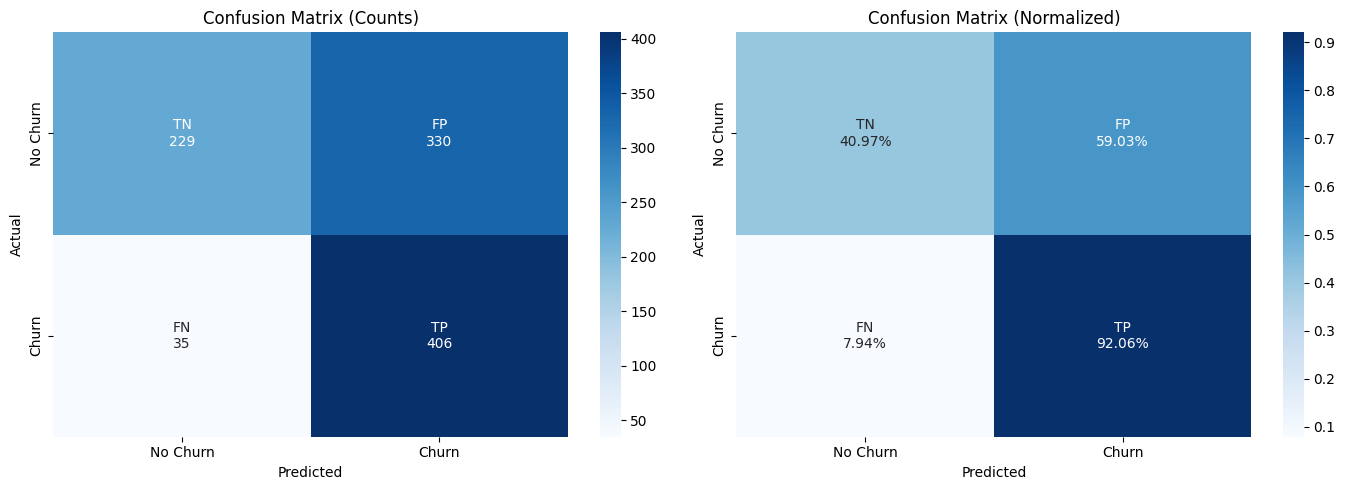

In [21]:
# Visualization: Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
cm = confusion_matrix(y_clf_test, clf_predictions)

# Create annotations with labels (TN, FP, FN, TP)
labels = np.array([['TN', 'FP'], ['FN', 'TP']])
annot_counts = np.array([[f'{labels[i,j]}\n{cm[i,j]}' for j in range(2)] for i in range(2)])

sns.heatmap(cm, annot=annot_counts, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_pct = np.array([[f'{labels[i,j]}\n{cm_normalized[i,j]:.2%}' for j in range(2)] for i in range(2)])

sns.heatmap(cm_normalized, annot=annot_pct, fmt='', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

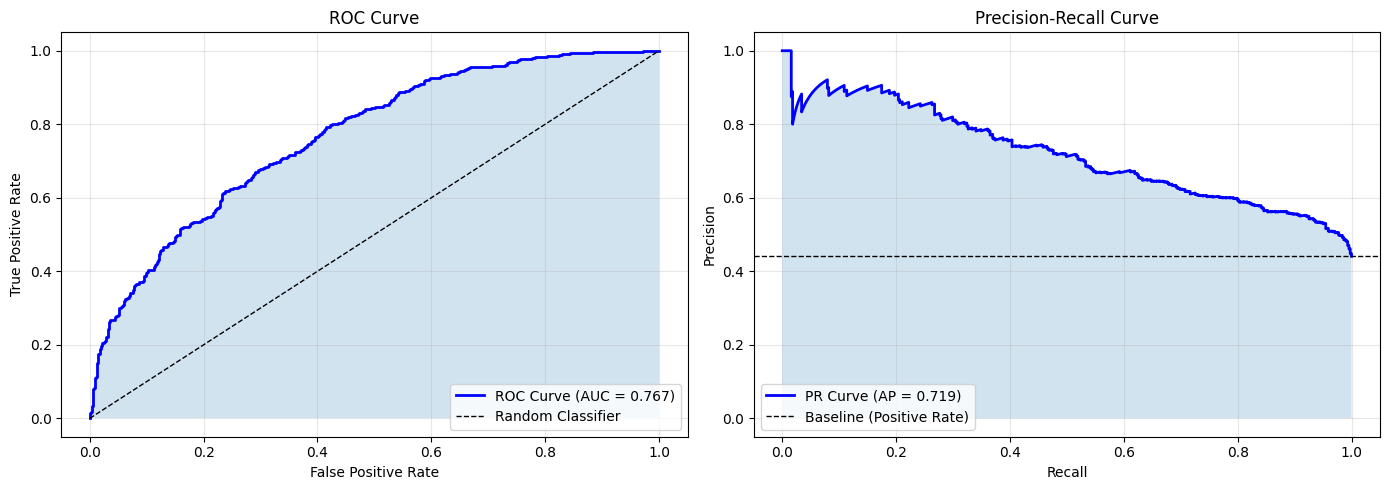

In [22]:
# Visualization: ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_clf_test, clf_scores)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {clf_metrics["roc_auc"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].fill_between(fpr, tpr, alpha=0.2)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_clf_test, clf_scores)
axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2, 
             label=f'PR Curve (AP = {clf_metrics["avg_precision"]:.3f})')
axes[1].axhline(y=y_clf_test.mean(), color='k', linestyle='--', linewidth=1, label='Baseline (Positive Rate)')
axes[1].fill_between(recall_curve, precision_curve, alpha=0.2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

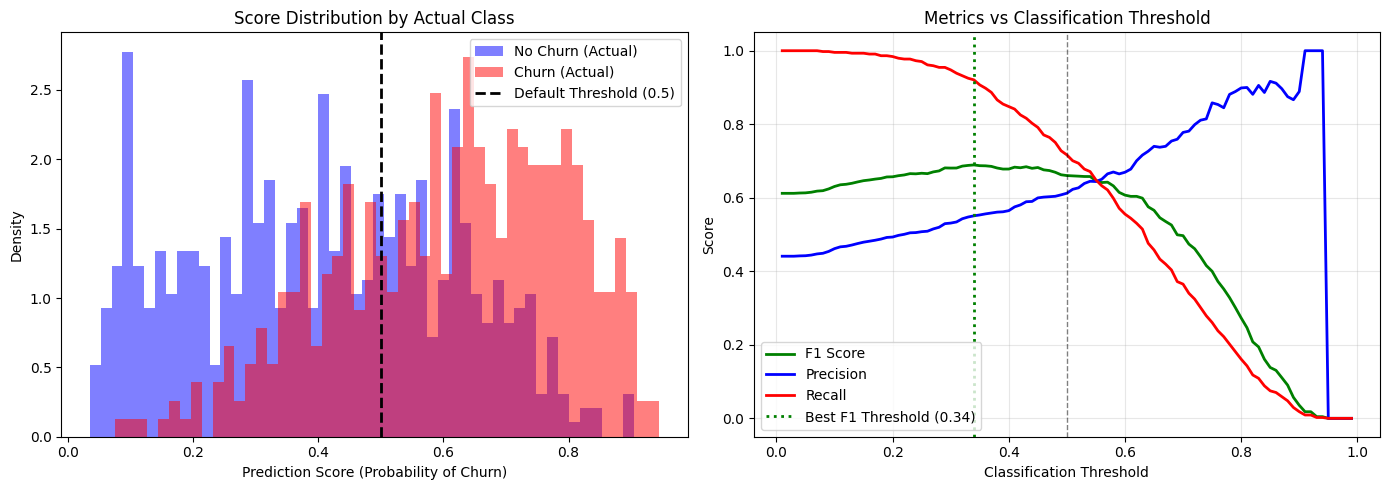


Optimal threshold for F1 Score: 0.340
F1 Score at optimal threshold: 0.6893


In [23]:
# Visualization: Score Distribution and Threshold Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score distribution by actual class
axes[0].hist(clf_scores[y_clf_test == 0], bins=50, alpha=0.5, label='No Churn (Actual)', color='blue', density=True)
axes[0].hist(clf_scores[y_clf_test == 1], bins=50, alpha=0.5, label='Churn (Actual)', color='red', density=True)
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
axes[0].set_xlabel('Prediction Score (Probability of Churn)')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Distribution by Actual Class')
axes[0].legend()

# Threshold analysis
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds:
    y_pred_thresh = (clf_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_clf_test, y_pred_thresh, zero_division=0))
    precisions.append(precision_score(y_clf_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_clf_test, y_pred_thresh, zero_division=0))

axes[1].plot(thresholds, f1_scores, 'g-', linewidth=2, label='F1 Score')
axes[1].plot(thresholds, precisions, 'b-', linewidth=2, label='Precision')
axes[1].plot(thresholds, recalls, 'r-', linewidth=2, label='Recall')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
best_thresh = thresholds[np.argmax(f1_scores)]
axes[1].axvline(x=best_thresh, color='green', linestyle=':', linewidth=2, label=f'Best F1 Threshold ({best_thresh:.2f})')
axes[1].set_xlabel('Classification Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics vs Classification Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold for F1 Score: {best_thresh:.3f}")
print(f"F1 Score at optimal threshold: {max(f1_scores):.4f}")

---

# Part B: Regression (House Price Prediction)

## Step 5B: Configure and Train the Regression Model

### Regression-Specific Hyperparameters

Most hyperparameters are the same as classification (epochs, mini_batch_size, learning_rate, optimizer, l1, wd, normalize_data, num_models). Below are the key differences for regression:

**predictor_type**
- Set to `regressor` for predicting continuous values
- Internally uses squared error loss instead of logistic loss

**normalize_label**
- Set to `true` for regression (unlike classification where it's `false`)
- Why? House prices range from $50K to $1M+. Without normalization:
  - Gradients can explode (very large error values)
  - Learning becomes unstable
- With normalization, SageMaker internally transforms labels to zero mean, unit variance
- Predictions are automatically transformed back to original scale

**loss**
- The function the model minimizes during training
- `squared_loss`: Standard Mean Squared Error—penalizes large errors heavily (squares them)
  - Good default for most regression problems
  - Sensitive to outliers (a $500K error contributes 250 billion to loss)
- `absolute_loss`: Mean Absolute Error—treats all errors linearly
  - More robust to outliers
  - Use when your data has extreme values you don't want to dominate training
- `huber_loss`: Combination—squared for small errors, linear for large errors
  - Best of both worlds: sensitive to small errors, robust to outliers
  - Requires tuning the `huber_delta` parameter
- `eps_insensitive_squared_loss` / `eps_insensitive_absolute_loss`: Ignore errors below a threshold
  - Used in Support Vector Regression
  - Good when small prediction errors are acceptable

### Why Different Normalization for Regression?

**Classification labels (0 or 1)**:
- Already on a small, bounded scale
- No benefit from normalization

**Regression labels (e.g., $50,000 - $900,000)**:
- Huge numeric range
- Gradient descent takes tiny steps relative to these large values
- Normalization makes the optimization landscape smoother
- Without it, you'd need an extremely small learning rate

### Model Selection for Regression

When `num_models: "auto"`, Linear Learner trains multiple models and selects the best based on:
- Validation loss (squared error on held-out data)
- The model with lowest validation loss is chosen

Unlike classification, there's no `model_selection_criteria` parameter—regression always optimizes for prediction error.

In [ ]:
# Create the regression estimator
reg_estimator = Estimator(
    image_uri=linear_learner_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/regression/output',
    sagemaker_session=sagemaker_session,
    base_job_name='linear-learner-housing'
)

In [ ]:
# Set regression hyperparameters
reg_hyperparameters = {
    # Task type
    "predictor_type": "regressor",
    
    # Number of features
    "feature_dim": X_reg_train.shape[1],
    
    # Training parameters
    "epochs": 15,
    "mini_batch_size": 200,
    
    # Regularization
    "l1": 0.001,
    "wd": 0.0001,  # L2 weight decay
    
    # Optimization
    "learning_rate": 0.1,
    "optimizer": "adam",
    
    # Model selection
    "num_models": "auto",
    
    # Normalization (important for linear models!)
    "normalize_data": "true",
    "normalize_label": "true",  # Normalize labels for regression
    
    # Loss function
    "loss": "squared_loss",  # Standard MSE loss
}

reg_estimator.set_hyperparameters(**reg_hyperparameters)

print("Regression Hyperparameters:")
for k, v in reg_hyperparameters.items():
    print(f"  {k}: {v}")

In [ ]:
# Define training input
reg_train_input = TrainingInput(
    s3_data=f's3://{BUCKET_NAME}/{reg_train_s3}',
    content_type='text/csv'
)

print("Starting regression training job...")
print("This will take approximately 3-5 minutes.\n")

reg_estimator.fit({'train': reg_train_input}, wait=True, logs=True)

In [ ]:
# Get training job info
reg_training_job = reg_estimator.latest_training_job.name
print(f"Regression training job completed: {reg_training_job}")
print(f"Model artifacts: {reg_estimator.model_data}")

## Step 6B: Run Batch Transform for Regression Predictions

In [ ]:
# Create a transformer for batch predictions
# Using application/json to get the score in JSON format
reg_transformer = reg_estimator.transformer(
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/regression/batch-output',
    accept='application/json',  # JSON format for consistency
    assemble_with='Line'
)

print("Starting batch transform job for regression...")
print("This will take approximately 3-5 minutes.\n")

# Run batch transform
reg_transformer.transform(
    data=f's3://{BUCKET_NAME}/{reg_test_s3}',
    content_type='text/csv',
    split_type='Line',
    wait=True,
    logs=True
)

print(f"\nBatch transform completed!")
print(f"Output location: {reg_transformer.output_path}")

In [ ]:
# Download and parse batch transform results
reg_output_key = f"{PREFIX}/regression/batch-output/test_features.csv.out"

# Download results
s3_client.download_file(BUCKET_NAME, reg_output_key, 'data/regression/predictions.csv')

# Parse predictions
# Linear Learner JSON output format: {"predictions": [{"score": 123456.78}, ...]}
reg_predictions = []

with open('data/regression/predictions.csv', 'r') as f:
    content = f.read().strip()
    result = json.loads(content)

    # Check if it's the batch format (all predictions in one object)
    if 'predictions' in result:
        for pred in result['predictions']:
            reg_predictions.append(pred['score'])
    else:
        # Single prediction format
        reg_predictions.append(result['score'])

reg_predictions = np.array(reg_predictions)

# Save predictions and test labels locally for later use (skip retraining)
np.save('data/regression/reg_predictions.npy', reg_predictions)
np.save('data/regression/y_reg_test.npy', y_reg_test)

print(f"Loaded {len(reg_predictions)} predictions")
print(f"Prediction range: ${reg_predictions.min():,.0f} - ${reg_predictions.max():,.0f}")
print(f"\nSaved locally: reg_predictions.npy, y_reg_test.npy")

## Step 7B: Comprehensive Regression Model Evaluation

We'll calculate all standard regression metrics and create visualizations.

### Understanding Regression Metrics

#### Error Metrics (in original units)

**MAE (Mean Absolute Error)**
- Formula: `mean(|actual - predicted|)`
- What it measures: Average prediction error in the same units as the target (dollars for house prices)
- **Interpretation**:
  - MAE of $25,000 means predictions are off by $25K on average
  - Easy to explain to stakeholders: "Our model is accurate within $25K on average"
  - Treats all errors equally—a $10K error and a $100K error contribute proportionally
- When to use: When all errors matter equally regardless of size

**RMSE (Root Mean Square Error)**
- Formula: `sqrt(mean((actual - predicted)^2))`
- What it measures: Similar to MAE, but penalizes large errors more heavily
- **Interpretation**:
  - Always >= MAE (equal only if all errors are identical)
  - Large gap between RMSE and MAE indicates some predictions have very large errors
  - RMSE of $35K with MAE of $25K suggests a few big misses
- When to use: When large errors are particularly problematic (e.g., grossly overpricing a house)

**Median Absolute Error**
- Formula: `median(|actual - predicted|)`
- What it measures: The "typical" error—half of predictions are better, half are worse
- **Interpretation**:
  - More robust to outliers than MAE
  - If Median AE << MAE, you have some very large errors pulling up the mean
  - Good for understanding typical case performance
- When to use: When you want to ignore extreme outliers

**Max Error**
- Formula: `max(|actual - predicted|)`
- What it measures: The worst single prediction
- **Interpretation**:
  - Identifies your model's biggest failure
  - Important for risk assessment—what's the worst case?
  - High max error with low MAE suggests one or two problematic cases
- When to use: Risk-sensitive applications where worst-case matters

#### Percentage Metrics (scale-independent)

**MAPE (Mean Absolute Percentage Error)**
- Formula: `mean(|actual - predicted| / actual) * 100`
- What it measures: Average error as a percentage of actual value
- **Interpretation**:
  - 10% MAPE means predictions are off by 10% on average
  - Allows comparison across different price ranges or datasets
  - **Caution**: Undefined or inflated when actual values are near zero
- **Quality benchmarks for real estate**:
  - < 5%: Excellent (rare in practice)
  - 5-10%: Very good
  - 10-15%: Good
  - 15-20%: Acceptable
  - > 20%: Needs improvement

**SMAPE (Symmetric Mean Absolute Percentage Error)**
- Formula: `mean(|actual - predicted| / ((|actual| + |predicted|) / 2)) * 100`
- What it measures: Like MAPE, but symmetric—treats over and under predictions equally
- **Interpretation**:
  - Ranges from 0% to 200%
  - More stable than MAPE when values vary widely
  - Better behaved near zero values
- When to use: Alternative to MAPE when you have values near zero or want symmetric treatment

#### Explained Variance Metrics

**R-squared (R2 / Coefficient of Determination)**
- Formula: `1 - (sum((actual - predicted)^2) / sum((actual - mean(actual))^2))`
- What it measures: Proportion of variance in the target explained by the model
- **Interpretation**:
  - 1.0 = perfect predictions
  - 0.0 = model is no better than predicting the mean for everything
  - Can be negative if model is worse than mean prediction
  - 0.85 means the model explains 85% of price variation
- **Quality benchmarks**:
  - < 0.50: Poor—model explains less than half the variance
  - 0.50-0.70: Moderate—useful but significant unexplained variance
  - 0.70-0.85: Good—model captures most important patterns
  - 0.85-0.95: Very good—strong predictive power
  - > 0.95: Excellent (or possibly overfitting—validate carefully)

**Adjusted R-squared**
- Formula: `1 - (1 - R2) * (n - 1) / (n - p - 1)` where n=samples, p=features
- What it measures: R2 penalized for number of features
- **Interpretation**:
  - Prevents inflated R2 from adding useless features
  - Always <= R2 (equal when features are truly helpful)
  - Use when comparing models with different numbers of features
- When to use: Model comparison, feature selection

**Explained Variance Score**
- Similar to R2, but doesn't penalize bias in predictions
- If your model consistently over/under predicts by a constant amount, explained variance will be higher than R2
- R2 is generally preferred

#### Residual Analysis

**Residual Mean**
- Should be close to zero for an unbiased model
- Positive mean: model tends to under-predict
- Negative mean: model tends to over-predict

**Residual Standard Deviation**
- Measures consistency of errors
- Lower is better—predictions are consistently accurate

**Within X% Accuracy**
- What percentage of predictions fall within 5%, 10%, 20% of actual value
- Practical metric for business applications
- "80% of our predictions are within 10% of actual price"

### Interpreting Residual Plots

**Actual vs Predicted Plot**
- Points should cluster tightly around the diagonal line
- Spread increasing with price suggests heteroscedasticity (model less accurate for expensive homes)

**Residuals vs Predicted Plot**
- Should show random scatter around zero (horizontal band)
- Patterns indicate model problems:
  - Funnel shape: Variance increases with predicted value
  - Curved pattern: Non-linear relationship not captured
  - Clusters: Distinct groups the model treats differently

**Q-Q Plot**
- Compares residual distribution to normal distribution
- Points on the diagonal = normally distributed residuals
- S-curve or deviations at ends = non-normal residuals (outliers, skew)

### Context for This Exercise

Our synthetic house price data has $30,000 random noise built in. Expected performance:
- RMSE: ~$30,000-40,000 (noise floor plus model error)
- R2: ~0.85-0.95 (linear model should capture the linear relationships well)
- MAPE: ~8-12% (relative to average price of ~$400K)

In [ ]:
# LOAD SAVED RESULTS - Run this cell to skip Steps 2-6B
# Only requires Step 1 (imports) to be run first
# Uncomment the lines below after you've run the full pipeline once

# reg_predictions = np.load('data/regression/reg_predictions.npy')
# y_reg_test = np.load('data/regression/y_reg_test.npy')
# print(f"Loaded {len(reg_predictions)} predictions from saved files")
# print(f"Prediction range: ${reg_predictions.min():,.0f} - ${reg_predictions.max():,.0f}")
# print(f"Test set size: {len(y_reg_test)}")
# print(f"Price range in test set: ${y_reg_test.min():,.0f} - ${y_reg_test.max():,.0f}")

In [ ]:
def evaluate_regression_model(y_true, y_pred):
    """
    Comprehensive evaluation of a regression model.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    metrics = {}
    
    # Error metrics
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['median_ae'] = median_absolute_error(y_true, y_pred)
    metrics['max_error'] = max_error(y_true, y_pred)
    
    # Percentage-based metrics
    metrics['mape'] = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # Symmetric MAPE (handles zeros better)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.where(denominator == 0, 1, denominator)  # Avoid division by zero
    metrics['smape'] = np.mean(np.abs(y_true - y_pred) / denominator) * 100
    
    # Explained variance metrics
    metrics['r2'] = r2_score(y_true, y_pred)
    metrics['explained_variance'] = explained_variance_score(y_true, y_pred)
    
    # Adjusted R2 (assuming we know the number of features)
    n = len(y_true)
    p = 10  # number of features
    metrics['adjusted_r2'] = 1 - (1 - metrics['r2']) * (n - 1) / (n - p - 1)
    
    # Residual statistics
    residuals = y_true - y_pred
    metrics['residual_mean'] = np.mean(residuals)
    metrics['residual_std'] = np.std(residuals)
    metrics['residual_median'] = np.median(residuals)
    
    # Within X% accuracy
    pct_errors = np.abs(residuals / y_true) * 100
    metrics['within_5pct'] = np.mean(pct_errors <= 5) * 100
    metrics['within_10pct'] = np.mean(pct_errors <= 10) * 100
    metrics['within_20pct'] = np.mean(pct_errors <= 20) * 100
    
    return metrics


def print_regression_report(metrics, value_prefix='$', title="Regression Metrics"):
    """Print a formatted regression report."""
    print("=" * 60)
    print(f" {title}")
    print("=" * 60)
    
    print("\n--- Error Metrics ---")
    print(f"  RMSE:               {value_prefix}{metrics['rmse']:,.0f}")
    print(f"  MAE:                {value_prefix}{metrics['mae']:,.0f}")
    print(f"  Median AE:          {value_prefix}{metrics['median_ae']:,.0f}")
    print(f"  Max Error:          {value_prefix}{metrics['max_error']:,.0f}")
    print(f"  MSE:                {metrics['mse']:,.0f}")
    
    print("\n--- Percentage Metrics ---")
    print(f"  MAPE:               {metrics['mape']:.2f}%")
    print(f"  SMAPE:              {metrics['smape']:.2f}%")
    
    print("\n--- Explained Variance ---")
    print(f"  R-squared (R2):     {metrics['r2']:.4f}")
    print(f"  Adjusted R2:        {metrics['adjusted_r2']:.4f}")
    print(f"  Explained Variance: {metrics['explained_variance']:.4f}")
    
    print("\n--- Residual Statistics ---")
    print(f"  Mean Residual:      {value_prefix}{metrics['residual_mean']:,.0f}")
    print(f"  Residual Std Dev:   {value_prefix}{metrics['residual_std']:,.0f}")
    print(f"  Median Residual:    {value_prefix}{metrics['residual_median']:,.0f}")
    
    print("\n--- Prediction Accuracy ---")
    print(f"  Within 5%:          {metrics['within_5pct']:.1f}%")
    print(f"  Within 10%:         {metrics['within_10pct']:.1f}%")
    print(f"  Within 20%:         {metrics['within_20pct']:.1f}%")
    print("=" * 60)

In [ ]:
# Calculate all regression metrics
reg_metrics = evaluate_regression_model(y_reg_test, reg_predictions)
print_regression_report(reg_metrics, value_prefix='$', title="House Price Regression Metrics")

In [ ]:
# Visualization: Actual vs Predicted with multiple views
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

residuals = y_reg_test - reg_predictions

# 1. Actual vs Predicted scatter plot
ax = axes[0, 0]
ax.scatter(y_reg_test, reg_predictions, alpha=0.3, s=10)
min_val = min(y_reg_test.min(), reg_predictions.min())
max_val = max(y_reg_test.max(), reg_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Price ($)')
ax.set_ylabel('Predicted Price ($)')
ax.set_title(f'Actual vs Predicted (R2 = {reg_metrics["r2"]:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Residuals vs Predicted
ax = axes[0, 1]
ax.scatter(reg_predictions, residuals, alpha=0.3, s=10)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.axhline(y=residuals.mean(), color='g', linestyle=':', linewidth=2, label=f'Mean: ${residuals.mean():,.0f}')
ax.fill_between([reg_predictions.min(), reg_predictions.max()], 
                [-2*residuals.std(), -2*residuals.std()],
                [2*residuals.std(), 2*residuals.std()], alpha=0.1, color='blue')
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Residual ($)')
ax.set_title('Residual Plot')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Residual distribution
ax = axes[1, 0]
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.axvline(x=residuals.mean(), color='green', linestyle=':', linewidth=2, 
           label=f'Mean: ${residuals.mean():,.0f}')
# Add normal distribution overlay
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
from scipy import stats
ax.plot(x_norm, stats.norm.pdf(x_norm, residuals.mean(), residuals.std()), 
        'r-', linewidth=2, label='Normal Fit')
ax.set_xlabel('Prediction Error ($)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Residuals')
ax.legend()

# 4. Percentage error distribution
ax = axes[1, 1]
pct_errors = (residuals / y_reg_test) * 100
ax.hist(pct_errors, bins=50, edgecolor='black', alpha=0.7, range=(-50, 50))
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.axvline(x=-10, color='green', linestyle=':', linewidth=1, alpha=0.7)
ax.axvline(x=10, color='green', linestyle=':', linewidth=1, alpha=0.7, label='+/- 10%')
ax.set_xlabel('Percentage Error (%)')
ax.set_ylabel('Count')
ax.set_title(f'Percentage Error Distribution (MAPE = {reg_metrics["mape"]:.2f}%)')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Additional visualization: Error by price range
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create price bins
price_bins = pd.cut(y_reg_test, bins=5)
bin_labels = [f'${int(b.left/1000)}K-${int(b.right/1000)}K' for b in price_bins.categories]

# MAE by price range
mae_by_bin = []
mape_by_bin = []
counts_by_bin = []

for i, bin_label in enumerate(price_bins.categories):
    mask = price_bins == bin_label
    if mask.sum() > 0:
        mae_by_bin.append(mean_absolute_error(y_reg_test[mask], reg_predictions[mask]))
        mape_by_bin.append(mean_absolute_percentage_error(y_reg_test[mask], reg_predictions[mask]) * 100)
        counts_by_bin.append(mask.sum())
    else:
        mae_by_bin.append(0)
        mape_by_bin.append(0)
        counts_by_bin.append(0)

x = range(len(bin_labels))

ax = axes[0]
bars = ax.bar(x, mae_by_bin, color='steelblue', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_xlabel('Price Range')
ax.set_ylabel('Mean Absolute Error ($)')
ax.set_title('MAE by Price Range')
# Add count labels
for i, (bar, count) in enumerate(zip(bars, counts_by_bin)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'n={count}', 
            ha='center', va='bottom', fontsize=9)

ax = axes[1]
bars = ax.bar(x, mape_by_bin, color='coral', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_xlabel('Price Range')
ax.set_ylabel('Mean Absolute Percentage Error (%)')
ax.set_title('MAPE by Price Range')
for i, (bar, count) in enumerate(zip(bars, counts_by_bin)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'n={count}', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Q-Q Plot for residuals (normality check)
fig, ax = plt.subplots(figsize=(8, 6))

from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals (Normality Check)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality (on a sample if dataset is large)
sample_size = min(5000, len(residuals))
sample_residuals = np.random.choice(residuals, size=sample_size, replace=False)
stat, p_value = stats.shapiro(sample_residuals)
print(f"Shapiro-Wilk Test for Normality:")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Residuals {'appear' if p_value > 0.05 else 'do not appear'} normally distributed (alpha=0.05)")

---

## Step 8: Clean Up S3 Data (Optional)

In [ ]:
# Uncomment to delete S3 data

# import boto3
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(BUCKET_NAME)
# bucket.objects.filter(Prefix=PREFIX).delete()
# print(f"Deleted all objects under s3://{BUCKET_NAME}/{PREFIX}")

---

## Summary

In this exercise, you learned:

### Data Format
- Linear Learner accepts CSV format with label in the first column (for training)
- For batch transform inference, provide features only (no label column)
- Normalization is handled automatically by the algorithm

### Batch Transform
- More cost-effective than endpoints for batch predictions
- No cleanup required - resources terminate after job completes
- Ideal for model evaluation and offline scoring

### Classification Metrics Covered
| Metric | Description |
|--------|-------------|
| Accuracy | Overall correctness |
| Balanced Accuracy | Average of recall for each class |
| Precision | True positives / Predicted positives |
| Recall (Sensitivity) | True positives / Actual positives |
| Specificity | True negatives / Actual negatives |
| F1 Score | Harmonic mean of precision and recall |
| ROC AUC | Area under the ROC curve |
| Average Precision | Area under the precision-recall curve |
| Log Loss | Logarithmic loss (probabilistic) |
| Matthews Correlation | Correlation between predicted and actual |

### Regression Metrics Covered
| Metric | Description |
|--------|-------------|
| RMSE | Root Mean Square Error |
| MAE | Mean Absolute Error |
| Median AE | Median Absolute Error (robust to outliers) |
| Max Error | Worst case error |
| MAPE | Mean Absolute Percentage Error |
| SMAPE | Symmetric MAPE |
| R-squared | Coefficient of determination |
| Adjusted R2 | R2 adjusted for number of predictors |
| Explained Variance | Proportion of variance explained |

### Key Hyperparameters
| Parameter | Description |
|-----------|-------------|
| `predictor_type` | binary_classifier, multiclass_classifier, or regressor |
| `feature_dim` | Number of features (required) |
| `num_models` | Number of parallel models to train |
| `normalize_data` | Normalize features (recommended) |
| `l1` | L1 regularization strength |
| `wd` | L2 regularization (weight decay) |
| `learning_rate` | Learning rate |

### Best Practices
1. **Always normalize data** - Set `normalize_data: true`
2. **Use regularization** - Helps prevent overfitting
3. **Train multiple models** - Set `num_models: auto` for automatic tuning
4. **Use Batch Transform** - More cost-effective than endpoints for evaluation
5. **Check multiple metrics** - Don't rely on a single metric for evaluation

## Resources

- [Linear Learner Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)
- [Linear Learner Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)
- [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html)
- [SageMaker Python SDK](https://sagemaker.readthedocs.io/)